---

---

### Imports

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [44]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, imagenet_utils
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
#import tqdm

#### Reset the session when you wish to reinitialise a different architecture

In [13]:
K.clear_session()
keras.__version__

'2.2.4-tf'

#### Instantiate Mobilenet

In [14]:
model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(254, 254, 3)))

#### Prepare an image for MobileNet
* read into an array
* ensure the shape is correct
* for both steps, we can use a mixture of `opencv` and `numpy`

In [15]:
def process_for_model(file):
    image = cv2.imread(file)
    image = cv2.resize(image, dsize=(254,254),interpolation=cv2.INTER_CUBIC)
#    image = preprocess_input(image)
    return image

#### We're going to add a dimension so that mobilenet accepts it

In [16]:
corona = process_for_model('C:/Users/casti/Documents/COVID-19-imaging_analysis_Juan/keras-covid-19/keras-covid-19/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg')

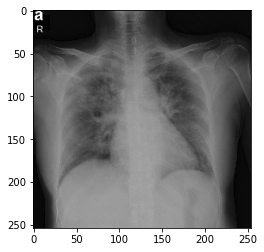

In [17]:
plt.imshow(corona)

#### Test Mobilenet on the image to test it works

In [18]:
print(corona.shape)
corona= np.expand_dims(corona, axis=0)
corona.shape

(254, 254, 3)


(1, 254, 254, 3)

In [19]:
predictions=model.predict(corona)

In [21]:
predictions

array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  1.7754909],
         [24.419971 ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [10.006036 , 12.560245 ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 3.1895654, 14.643637 ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 1.9362863,  9.571897 ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[10.688836 ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [28.654995 ,  0.       ,  0.       , ..., 13.685549 ,
           0.       ,  0.       ],
         [ 0.3501854,  0.       ,  0.       , ...,  5.9588375,
           0.       ,  0.       ],
         ...,
         [ 4.9279165,  6.4717216,  0.       , ..., 10.573573 ,
           5.6154437,  0.

#### Now onto the real task, Transfer Learning

---

### Part 1: Chop and Customise

#### We chop when we import

In [22]:
new_mobile = VGG16(weights='imagenet', include_top=False, input_shape=(254,254,3))

#### And check the layers

In [23]:
new_mobile.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 254, 254, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 254, 254, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 127, 127, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 127, 127, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 127, 127, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 63, 63, 128)       0     

In [24]:
new_mobile.layers

In [25]:
len(new_mobile.layers)

19

#### Now add our own custom layers - the syntax here is different from the usual keras model creation
* First create your new_layer variable
* Then build a Keras `Model`, with inputs = the old mobilenet, and outputs = the new layers

In [27]:
new_layers = new_mobile.output
new_layers = GlobalAveragePooling2D()(new_layers)
new_layers = Dense(1024, activation='relu')(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dense(2, activation='sigmoid')(new_layers)

In [28]:
new_mobile = Model(inputs=new_mobile.inputs, outputs=new_layers)

### 2: Freeze the layer weights that we don't want to train

In [29]:
len(new_mobile.layers)

24

In [30]:
for i, layer in enumerate(new_mobile.layers):
    if i <19:
        layer.trainable = False
    else:
        layer.trainable = True

### 3: Prepare our images
#### First, take a look at an example

#### Now read in each image, and resize and preprocess it. We can also create our y data at the same time

In [31]:
X = []
y = []
path = 'C:/Users/casti/Documents/COVID-19-imaging_analysis_Juan/keras-covid-19/both/'

train_data = os.listdir(path)

for picture in train_data:
    image = process_for_model(path+picture)
    X.append(image)
    if 'corona' in picture:
        y.append(0)
    else:
        y.append(1) 
X = np.array(X)
y = np.array(y)

#### The overall shape of X needs to be (no.of.images, 224,224,3), and y needs to be (no.of.images,no.of_classes)
* The shape of X should already be ok (but use `np.expand_dims` if you have one pic only)
* But we can reshape y using `keras.utils.np_utils.to_categorical`

In [32]:
from tensorflow.keras.utils import to_categorical

In [33]:
y = to_categorical(y, num_classes=2)

In [34]:
X.shape, y.shape

((50, 254, 254, 3), (50, 2))

In [35]:
y[0]

array([1., 0.], dtype=float32)

#### Finally, lets do a train/test split

In [36]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, random_state=42, test_size=0.2)
#(trainX, testX, trainY, testY) = train_test_split(, labels, test_size=0.20, random_state=42)

### 4: Train and test!
#### Compile, fit and evaluate

In [37]:
new_mobile.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
results = new_mobile.fit(X_TRAIN, Y_TRAIN, epochs=5, batch_size=4, validation_split=0.2)

Train on 32 samples, validate on 8 samples
Epoch 1/5
32/32 [==============================] - 14s 440ms/sample - loss: 7.1136 - accuracy: 0.5625 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 2/5
32/32 [==============================] - 15s 455ms/sample - loss: 7.0517 - accuracy: 0.5625 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 3/5
32/32 [==============================] - 15s 478ms/sample - loss: 7.0517 - accuracy: 0.5625 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 4/5
32/32 [==============================] - 16s 493ms/sample - loss: 7.0517 - accuracy: 0.5625 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 5/5
32/32 [==============================] - 16s 498ms/sample - loss: 7.0517 - accuracy: 0.5625 - val_loss: 8.0590 - val_accuracy: 0.5000


In [56]:
Y_PRED = new_mobile.predict(X_TEST, batch_size=4) 

In [60]:
Y_PRED

array([[9.9988151e-01, 8.0100976e-24],
       [9.9947029e-01, 4.4377306e-22],
       [9.9999893e-01, 1.1824707e-38],
       [9.9983776e-01, 5.4716957e-23],
       [9.9999690e-01, 4.1531423e-32],
       [9.9980074e-01, 4.3337213e-23],
       [9.9999833e-01, 4.5747127e-34],
       [9.9999809e-01, 1.3119019e-35],
       [9.9968731e-01, 4.0197852e-21],
       [9.9966705e-01, 5.5545552e-23]], dtype=float32)

In [53]:
Y_PRED

4

In [41]:
Y_TEST

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [61]:
new_mobile.score(X_TEST, Y_TEST)

AttributeError: 'Model' object has no attribute 'score'

---

#### Further work:
* Save the model (json) with its current weights (h5) to disk
* And load from disk

#### Save the model

In [62]:
with open("model_Corona2.json", "w") as json_file:
   json_file.write(new_mobile.to_json())
# serialize weights to HDF5
new_mobile.save_weights("model_Corona2.h5")

#### Load the model

In [63]:
from tensorflow.keras.models import model_from_json

# load json and create model
with open('model_Corona2.json', 'r') as f:
   json = f.read()
model = model_from_json(json)

# load weights into new model
model.load_weights("model_Corona2.h5")